<a href="https://colab.research.google.com/github/leviettung200/Customer-Churn-Prediction/blob/main/Customer_Churn_Prediction_with_PySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Lib

In [ ]:
!sudo apt-get update

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz
!tar xf spark-3.0.3-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"

import findspark
findspark.init()


Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [867 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:13 http://ppa.laun

In [ ]:
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import  count, col, udf, avg, first, ceil, rand, isnull, first, col
from pyspark.sql.functions import min as fmin
from pyspark.sql.functions import max as fmax
import  pyspark.sql.functions as sql_func

from pyspark.sql.types import IntegerType, StringType
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder,CrossValidatorModel
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier

In [ ]:
import re
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sb
#set seaborn style
sns.set(style="whitegrid")
%matplotlib inline

In [ ]:
# create a Spark session
spark = SparkSession.builder\
        .master("local")\
        .appName("final-app")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [ ]:
# Spark UI
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok authtoken 2325vC6TSS9PMlt0LQs3zcrePAK_2RN3ML2775W8jxGmZUvb9')
get_ipython().system_raw('./ngrok http 4050 &')
!sleep 10
!curl -s http://localhost:4040/api/tunnels

--2022-01-13 03:09:23--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.161.241.46, 54.237.133.81, 18.205.222.128, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.161.241.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  17.4MB/s    in 0.8s    

2022-01-13 03:09:24 (17.4 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
{"tunnels":[{"name":"command_line","uri":"/api/tunnels/command_line","public_url":"https://92de-104-196-231-59.ngrok.io","proto":"https","config":{"addr":"http://localhost:4050","inspect":true},"metrics":{"conns":{"count":0,"gauge":0,"rate1":0,"rate5":0,"rate15":0,"p50":0,"p90":0,"p95":0,"p99":0},"http":{"count":0,"rate1":0,"rate5":0,"rate15":

# Load and Clean Dataset


## Scan Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!wget https://udacity-dsnd.s3.amazonaws.com/sparkify/sparkify_event_data.json
# df = spark.read.json('drive/My Drive/Dataset/sparkify_event_data.json')
df = spark.read.json('sparkify_event_data.json')
df.show(5)

--2022-01-13 03:10:08--  https://udacity-dsnd.s3.amazonaws.com/sparkify/sparkify_event_data.json
Resolving udacity-dsnd.s3.amazonaws.com (udacity-dsnd.s3.amazonaws.com)... 52.218.154.59
Connecting to udacity-dsnd.s3.amazonaws.com (udacity-dsnd.s3.amazonaws.com)|52.218.154.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12756856160 (12G) [application/json]
Saving to: ‘sparkify_event_data.json’

sparkify_event_data 100%[===================>]  11.88G  21.9MB/s    in 8m 40s  

2022-01-13 03:18:48 (23.4 MB/s) - ‘sparkify_event_data.json’ saved [12756856160/12756856160]

+--------------------+---------+---------+------+-------------+--------+----------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+-------+
|              artist|     auth|firstName|gender|itemInSession|lastName|    length|level|            location|method|    page| registration|sessionId|                song|status

In [ ]:
df.printSchema()
print('Shape of model_data: ({}, {})'.format(df.count(), len(df.columns)))

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

Shape of model_data: (26259199, 18)


## Clean Data

In [ ]:
df.filter(isnull(df['userId'])).count()

0

In [ ]:
df.filter(df['userId']=='').count()

0

In [ ]:
df.filter(isnull(df['sessionId'])).count()

0

In [ ]:
df_trash = df.filter("userId =='' or userId is NULL or sessionId is NULL ")
df_trash.count()

0

In [ ]:
df_cleaned = df.filter("userId !='' and userId is not NULL and sessionId is not NULL ")
df_cleaned.count()

26259199

In [ ]:
df_cleaned = df.filter("userId != '1261737' ")
df_cleaned.count()

25480720

In [ ]:
df_cleaned.show()

# Exploratory Data


In [ ]:
#Define Cancellation
cancel_churn = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df_cleaned = df_cleaned.withColumn("Cancel", cancel_churn("page"))

#Define Downgrade
downgrade_churn = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
df_cleaned = df_cleaned.withColumn("Downgrade", downgrade_churn("page"))

#Define Upgrade 
upgrade_churn = udf(lambda x: 1 if x == "Submit Upgrade" else 0, IntegerType())
df_cleaned = df_cleaned.withColumn("Upgrade", upgrade_churn("page"))

## Create User Time Span
time span column that records the time length between first and last log message.

In [ ]:
#Define window for time span calculation
windowSpec  = Window.partitionBy("userId")

#Create new column containing time span in days
df_cleaned = df_cleaned.withColumn("Time-Span", ceil((sql_func.max(col('ts')).over(windowSpec) - sql_func.min(col('ts')).over(windowSpec))/86400000))


In [ ]:
df_cleaned.show(5)

+------------------+---------+---------+------+-------------+--------+---------+-----+-----------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+-------+------+---------+-------+---------+
|            artist|     auth|firstName|gender|itemInSession|lastName|   length|level|   location|method|    page| registration|sessionId|                song|status|           ts|           userAgent| userId|Cancel|Downgrade|Upgrade|Time-Span|
+------------------+---------+---------+------+-------------+--------+---------+-----+-----------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+-------+------+---------+-------+---------+
|          Coldplay|Logged In|    Frank|     M|            0|  Warren|307.51302| free|Findlay, OH|   PUT|NextSong|1535470939000|     1623|              Clocks|   200|1538428238000|Mozilla/5.0 (Wind...|1000280|     0|        0|      0|       44|
|Charttraxx Karaoke|

In [ ]:
#Number of unique users (by ID)
Num_Unique_Users = df_cleaned.select('userId').distinct().count()
print("There are {} distinct users (by userID)".format(Num_Unique_Users))

#Number of different type of pages
Num_Unique_Pages = df_cleaned.select('page').distinct().count()
print("There are {} distinct page types (by userID)".format(Num_Unique_Pages))


There are 22277 distinct users (by userID)
There are 19 distinct page types (by userID)


## Explore Data

### User Activities

Text(0.5, 1.0, 'Distribution of Count of User Activities')

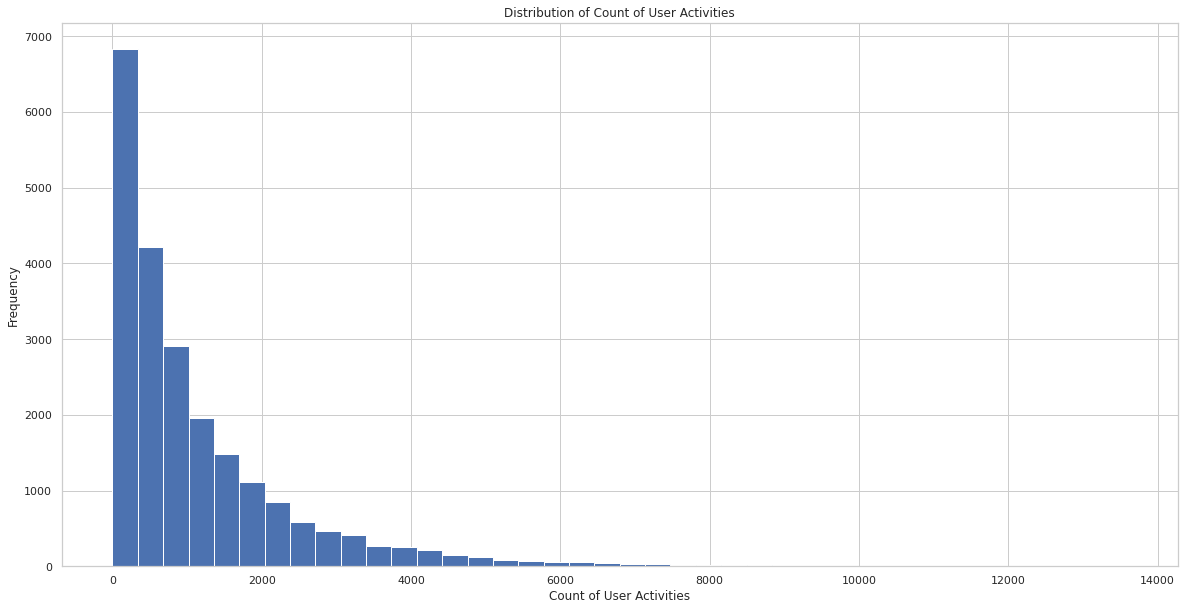

In [ ]:
#Plot count of user activities recorded in our dataset
user_count = df_cleaned.groupBy('userId').count().orderBy("count").toPandas()
plt.figure(figsize = [20,10])
plt.hist(user_count['count'], bins = 40)
plt.xlabel("Count of User Activities")
plt.ylabel("Frequency")
plt.title("Distribution of Count of User Activities")

### Activities by Page Type

Text(0.5, 1.0, 'Number of Page Activities Recorded VS Page Type')

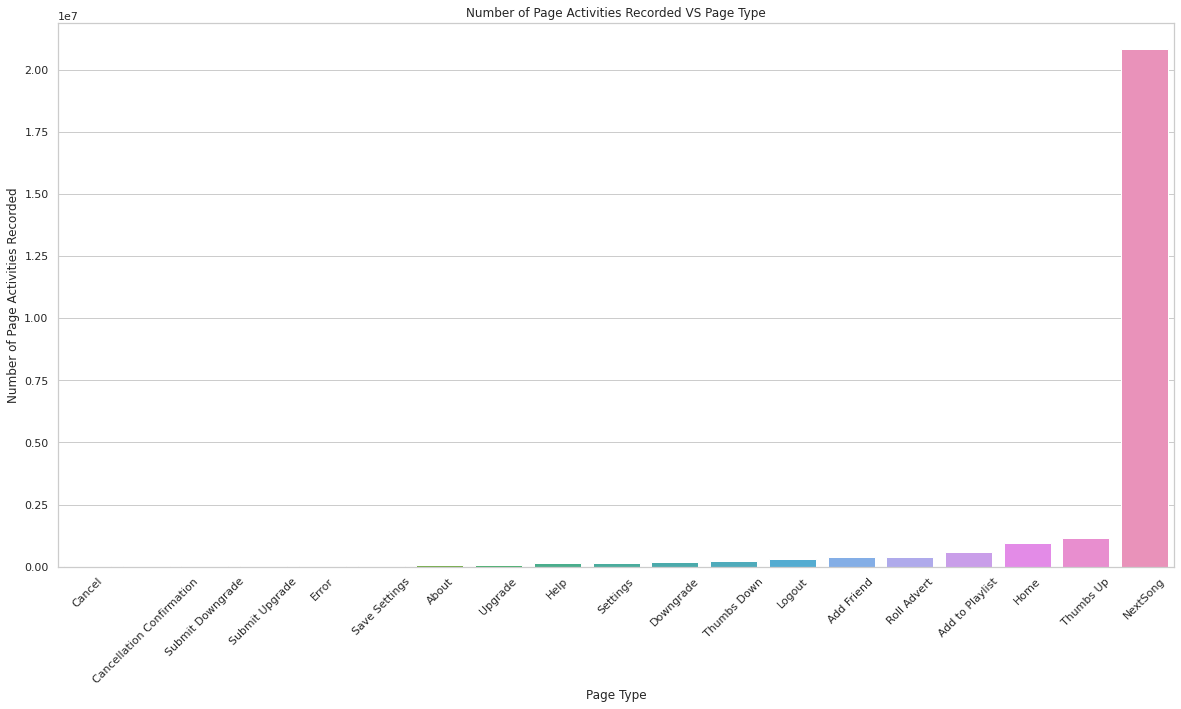

In [ ]:
#Plot number of page activities recorded by page type
page_count = df_cleaned.groupBy('page').count().sort("count", ascending = True).toPandas()
plt.figure(figsize = [20,10])
sb.barplot(x = 'page', y = 'count', data = page_count)
plt.xticks(rotation = 45)
plt.xlabel("Page Type")
plt.ylabel("Number of Page Activities Recorded")
plt.title("Number of Page Activities Recorded VS Page Type")

### User Gender

Text(0.5, 1.0, 'Number of Users by Gender')

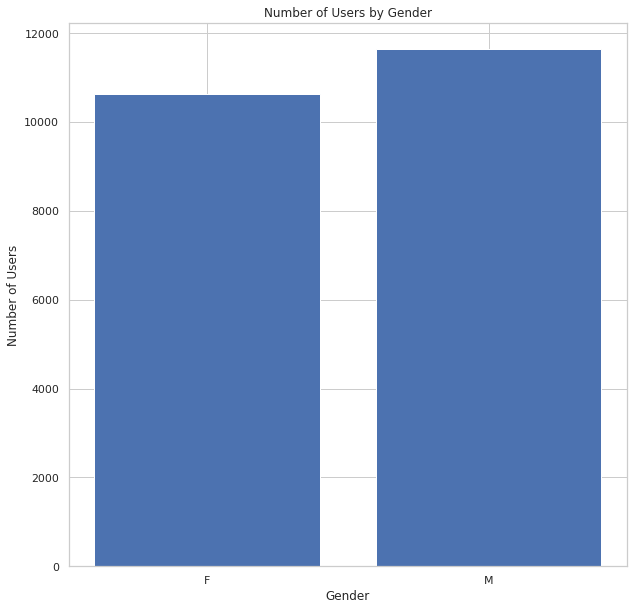

In [ ]:
#Plot number of users by gender
gender_count = df_cleaned.select(['gender','userId']).distinct().groupBy('gender').count().toPandas()
plt.figure(figsize = [10,10])
plt.bar(gender_count['gender'], gender_count['count'])
plt.xlabel("Gender")
plt.ylabel("Number of Users")
plt.title("Number of Users by Gender")

### Location

Text(0.5, 0, 'location')

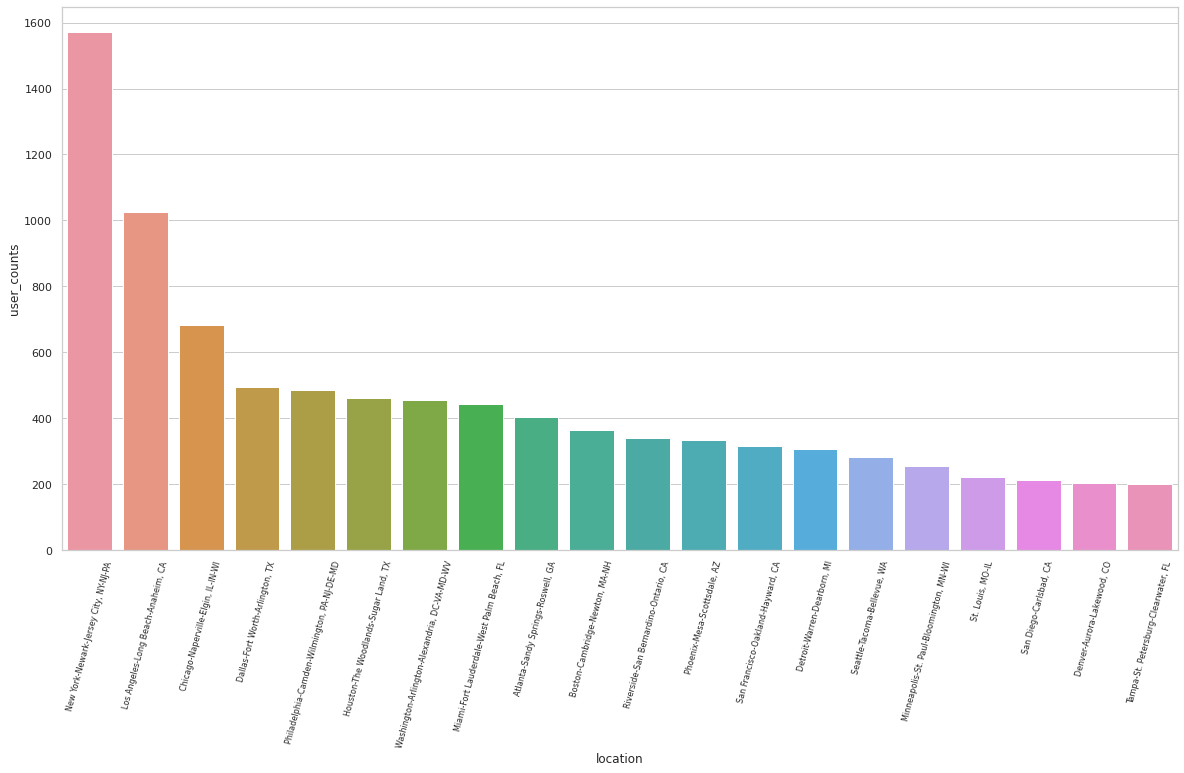

In [ ]:
df_cleaned.createOrReplaceTempView("local_cleaned")
locations = spark.sql('''
        SELECT location,COUNT(DISTINCT userId) AS user_counts
        FROM local_cleaned
        GROUP BY location
        ORDER BY user_counts DESC
        LIMIT 20;
''').toPandas()
#split city and state
plt.figure(figsize = [20,10])
sb.barplot(x = 'location', y = 'user_counts', data = locations)
plt.xticks(rotation = 75, fontsize=8)
plt.xlabel("location")



### Most Listened to Artist

Text(0.5, 1.0, 'Top 20 Most Listened to Artists')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0, flags=flags)


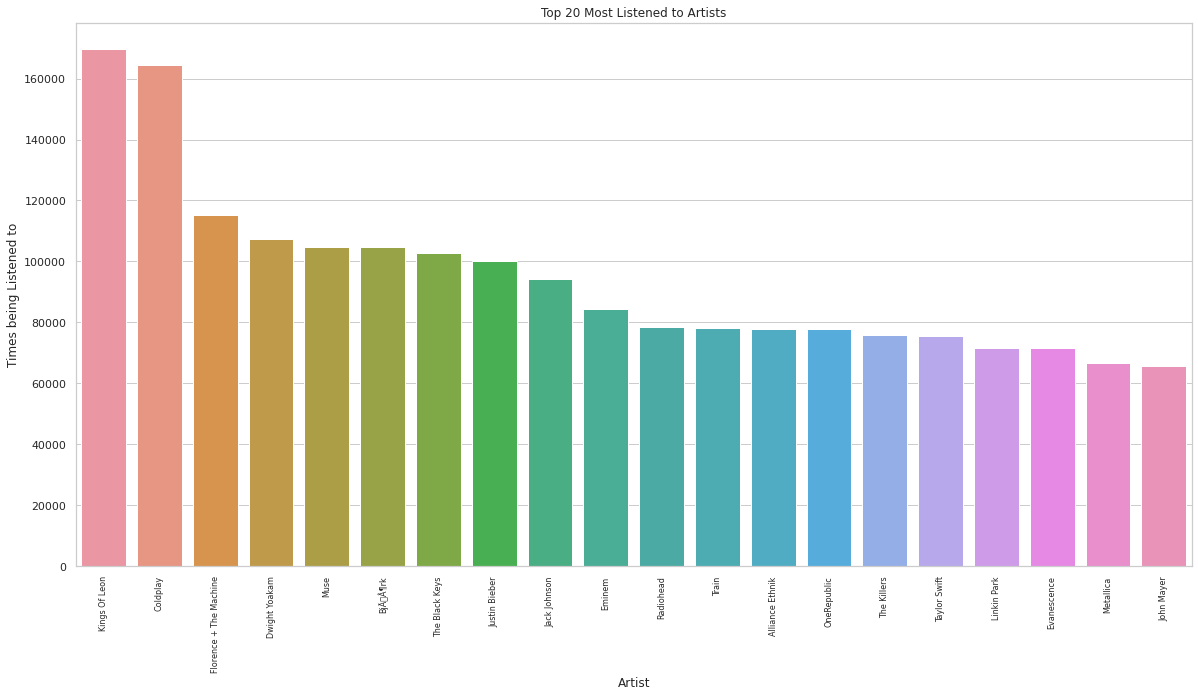

In [ ]:
#Groupby artist to get most listened to artist
artist = df_cleaned.groupBy('artist').count().sort('count', ascending = False).toPandas()
artist = artist.dropna()
artist = artist.iloc[:20,:]

#Plot the result of most listened to artist using barplot
plt.figure(figsize = [20,10])
sb.barplot(x = 'artist', y = 'count', data = artist)
plt.xticks(rotation = 90, fontsize=8)
plt.xlabel("Artist")
plt.ylabel("Times being Listened to")
plt.title("Top 20 Most Listened to Artists")

### Most Listened to Songs

Text(0.5, 1.0, 'Top 20 Most Listened to Songs')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0, flags=flags)


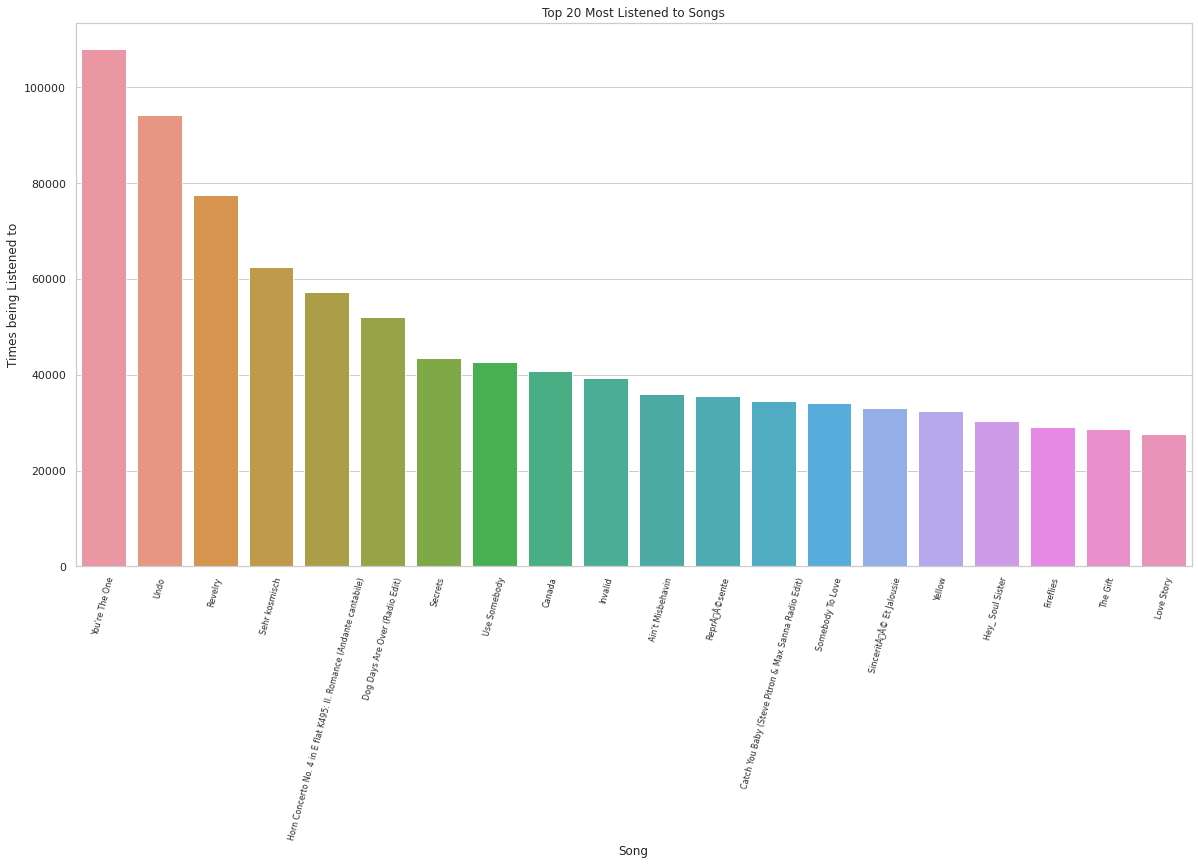

In [ ]:
#We groupby songs to filter out most listened to songs
songs = df_cleaned.groupBy('song').count().sort('count', ascending = False).toPandas()
songs = songs.dropna()
songs = songs.iloc[:20,:]

#We plot the barplot of 20 most listened songs
plt.figure(figsize = [20,10])
sb.barplot(x = 'song', y = 'count', data = songs)
plt.xticks(rotation = 75, fontsize=8)
plt.xlabel("Song")
plt.ylabel("Times being Listened to")
plt.title("Top 20 Most Listened to Songs")

## Define Churned Column

In [ ]:
#number of churned users
num_churn_user = df_cleaned.filter(df_cleaned['Cancel'] == 1).groupBy('userId').count().count()

print("There are {} churned (Cancellation) users, the ratio of churned users is {}%".format(num_churn_user, round(num_churn_user/Num_Unique_Users,4)*100))

There are 5003 churned (Cancellation) users, the ratio of churned users is 22.46%


In [ ]:
#Create user table that check if  user has ever churned
churned_users_table = df_cleaned.groupBy('userId').agg(sql_func.max('Cancel').alias('Churned'))
churned_users = list(churned_users_table.filter(churned_users_table['Churned'] == 1).select('userId').toPandas()['userId'])

#Define udf to transform user churn state
churn_or_not = udf(lambda x: 1 if x in churned_users else 0, IntegerType())
df_cleaned = df_cleaned.withColumn('Churned', churn_or_not('userId'))

In [ ]:
churned_users_table.show()
churned_users

### Times of Downgrade V.S Churned or Not


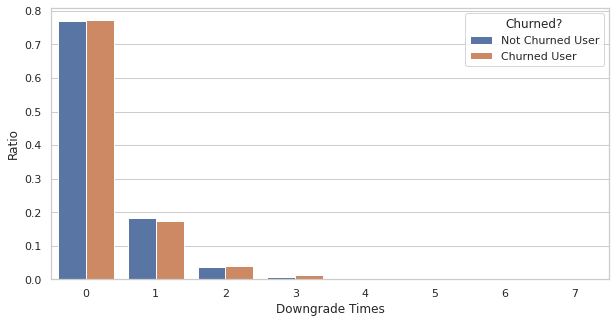

In [ ]:
#user upgrade times and then the ratio of times per user in that churn group
user_Downgrade_Times = df_cleaned.groupBy(['userId','Churned']).sum('Downgrade').groupBy(['Churned','sum(Downgrade)']).count().toPandas()
user_Downgrade_Times.loc[user_Downgrade_Times['Churned'] == 1,'count'] /= num_churn_user
user_Downgrade_Times.loc[user_Downgrade_Times['Churned'] == 0,'count'] /= (Num_Unique_Users - num_churn_user)

#plot the result
plt.figure(figsize = [10, 5])
churn_downgrade_bar = sb.barplot(x = 'sum(Downgrade)', y = 'count', data = user_Downgrade_Times, hue = 'Churned')
plt.ylabel('Ratio')
plt.xlabel('Downgrade Times')
h, l = churn_downgrade_bar.get_legend_handles_labels() 
churn_downgrade_bar.legend(h, ['Not Churned User', 'Churned User'], title='Churned?', loc = 'upper right')

### Times of Upgrade V.S Churned or Not

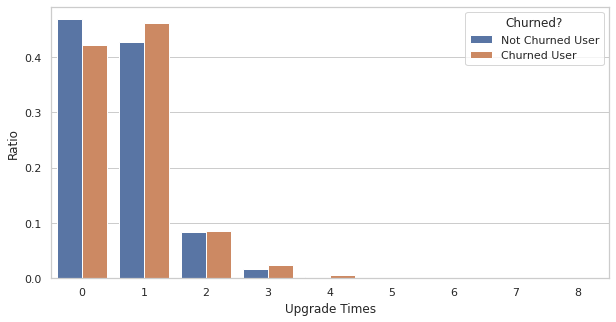

In [ ]:
#user upgrade times and then the ratio of times per user in that churn group
user_Upgrade_Times = df_cleaned.groupBy(['userId','Churned']).sum('Upgrade').groupBy(['Churned','sum(Upgrade)']).count().toPandas()
user_Upgrade_Times.loc[user_Upgrade_Times['Churned'] == 1,'count'] /= num_churn_user
user_Upgrade_Times.loc[user_Upgrade_Times['Churned'] == 0,'count'] /= (Num_Unique_Users - num_churn_user)

#plot the result
plt.figure(figsize = [10, 5])
churn_Upgrade_bar = sb.barplot(x = 'sum(Upgrade)', y = 'count', data = user_Upgrade_Times, hue = 'Churned')
plt.ylabel('Ratio')
plt.xlabel('Upgrade Times')
h, l = churn_Upgrade_bar.get_legend_handles_labels() 
churn_Upgrade_bar.legend(h, ['Not Churned User', 'Churned User'], title='Churned?', loc = 'upper right')

### Final Level
last level when users decide to cancel the service

Text(0.5, 1.0, 'Final_Level_Count by Churned Usr Group')

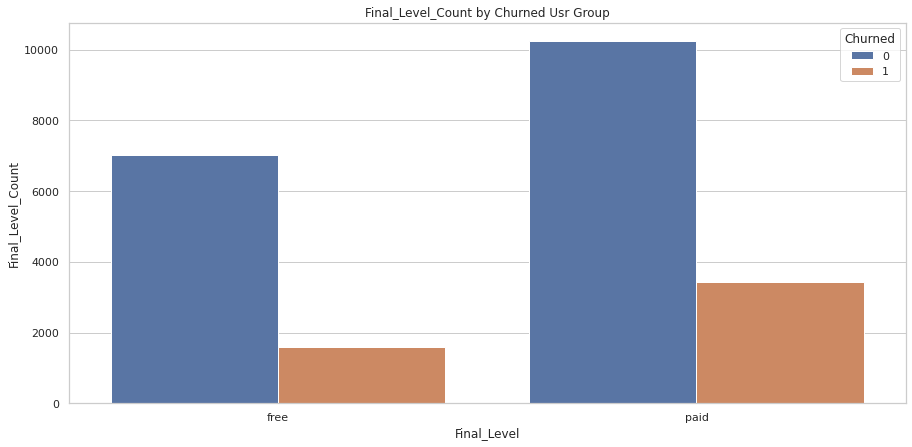

In [ ]:
#Create dataframe of final level of churned user
final_level = df_cleaned.orderBy(['userId','ts'],ascending = False).groupBy(['userId','Churned']).agg(first('level').alias('Final_Level'))
final_level_pd = final_level.groupBy(['Churned','Final_Level']).agg(count('Final_Level').alias("Final_Level_Count")).toPandas()
final_level = final_level.drop('Churned')

#Plot our result
plt.figure(figsize = [15, 7])
sb.barplot(x = final_level_pd['Final_Level'], y = final_level_pd["Final_Level_Count"], hue = final_level_pd['Churned'])
plt.title('Final_Level_Count by Churned Usr Group')

In [ ]:
temp_table = final_level_pd.groupby('Final_Level').sum()[['Final_Level_Count']]
temp_table.columns = ['Total Amount by Level']
final_level_pd = final_level_pd.join(temp_table, on = 'Final_Level', rsuffix='')
final_level_pd['Ratio By Level'] = final_level_pd['Final_Level_Count'] / final_level_pd['Total Amount by Level']
final_level_pd = final_level_pd[['Churned', 'Final_Level', 'Final_Level_Count', 'Ratio By Level']]
final_level_pd

,Churned,Final_Level,Final_Level_Count,Ratio By Level
0,0,free,7027,0.816523
1,0,paid,10247,0.749543
2,1,paid,3424,0.250457
3,1,free,1579,0.183477


### User Device

Text(0.5, 1.0, 'Device used by user')

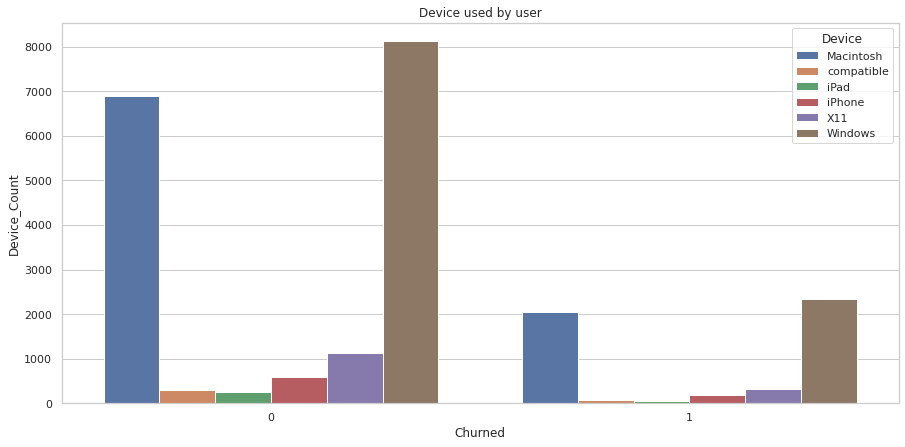

In [ ]:
def extract_device(col):
    """
    This function extraction device from column text
    
    Input: Text content of the column
    Output: Device name
    """
    device = re.findall(r'\([a-zA-Z0-9]*',col)[0].strip()[1:]
    return device

#Define user-defined device extraction function
get_device = udf(extract_device, StringType())

#Create new column as device
df_cleaned = df_cleaned.withColumn('Device', get_device('userAgent'))

#Create dataframe containing information of device of churned user groups
device_user = df_cleaned.groupBy(['userId','Churned']).agg(first('Device').alias('Device'))
device_user_pd = device_user.groupBy(['Churned','Device']).agg(count('Device').alias('Device_Count')).toPandas()
device_user = device_user.drop('Churned')

#Plot the result
plt.figure(figsize = [15, 7])
sb.barplot(x = device_user_pd['Churned'], y = device_user_pd['Device_Count'], hue = device_user_pd['Device'])
plt.title('Device used by user')

In [ ]:
temp_table = device_user_pd.groupby('Device').sum()[['Device_Count']]
temp_table.columns = ['Total Amount by Device']
device_user_pd = device_user_pd.join(temp_table, on = 'Device', rsuffix='')
device_user_pd['Ratio By Device'] = device_user_pd['Device_Count'] / device_user_pd['Total Amount by Device']
device_user_pd = device_user_pd[['Churned', 'Device', 'Device_Count', 'Ratio By Device']]

device_user_pd.sort_values(by = 'Device')

,Churned,Device,Device_Count,Ratio By Device
0,1,Macintosh,2042,0.228796
11,0,Macintosh,6883,0.771204
9,1,Windows,2334,0.223114
10,0,Windows,8127,0.776886
5,0,X11,1121,0.782821
8,1,X11,311,0.217179
1,0,compatible,298,0.809783
7,1,compatible,70,0.190217
2,0,iPad,249,0.800643
3,1,iPad,62,0.199357


### Thums Ups per Day

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


The mean value of thumbs up per day by churned user groups are:
Churned Users: 2.1365027329999573
Non-Churned Users: 1.1726747058598803


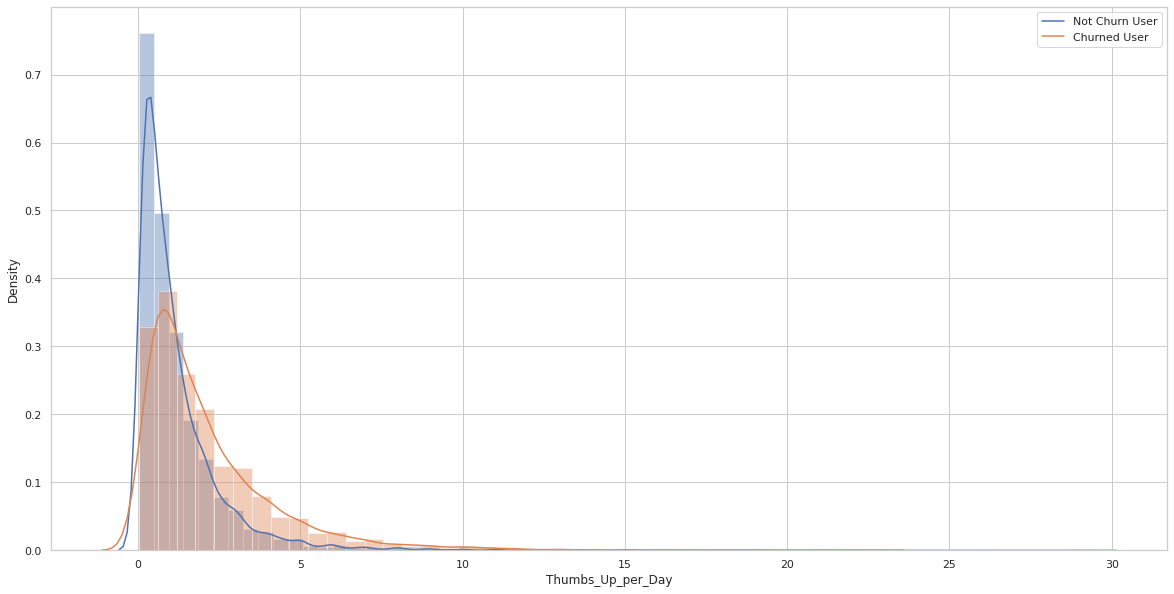

In [ ]:
#Create unique songs by user gorup dataframe
thumbs_up_day_user = df_cleaned.filter(df_cleaned['page'] == 'Thumbs Up').groupBy(['userId','Churned','Time-Span']).agg(count('page').alias('Thumbs_Up_Times'))
thumbs_up_day_user = thumbs_up_day_user.withColumn('Thumbs_Up_per_Day', col("Thumbs_Up_Times")/col('Time-Span'))
thumbs_up_day_user_pd = thumbs_up_day_user.toPandas()
thumbs_up_day_user = thumbs_up_day_user.drop('Churned','Thumbs_Up_Times','Time-Span')

#Plot our result 
plt.figure(figsize = [20,10])
sb.distplot(thumbs_up_day_user_pd[thumbs_up_day_user_pd['Churned'] == 0]['Thumbs_Up_per_Day'])
sb.distplot(thumbs_up_day_user_pd[thumbs_up_day_user_pd['Churned'] == 1]['Thumbs_Up_per_Day'])
plt.legend(['Not Churn User','Churned User'])

#Print out textual conclusion of our result
thumbs_up_day_user_nonchurn = thumbs_up_day_user_pd[thumbs_up_day_user_pd['Churned'] == 0]['Thumbs_Up_per_Day'].mean()
thumbs_up_day_user_churn = thumbs_up_day_user_pd[thumbs_up_day_user_pd['Churned'] == 1]['Thumbs_Up_per_Day'].mean()
print("The mean value of thumbs up per day by churned user groups are:\nChurned Users: {}\nNon-Churned Users: {}".format(thumbs_up_day_user_churn, thumbs_up_day_user_nonchurn))

### Thumbs Down per Day

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


The mean value of thumbs down per day by churned user grodowns are:
Churned Users: 0.6116366044929644
Non-Churned Users: 0.2579894023128341


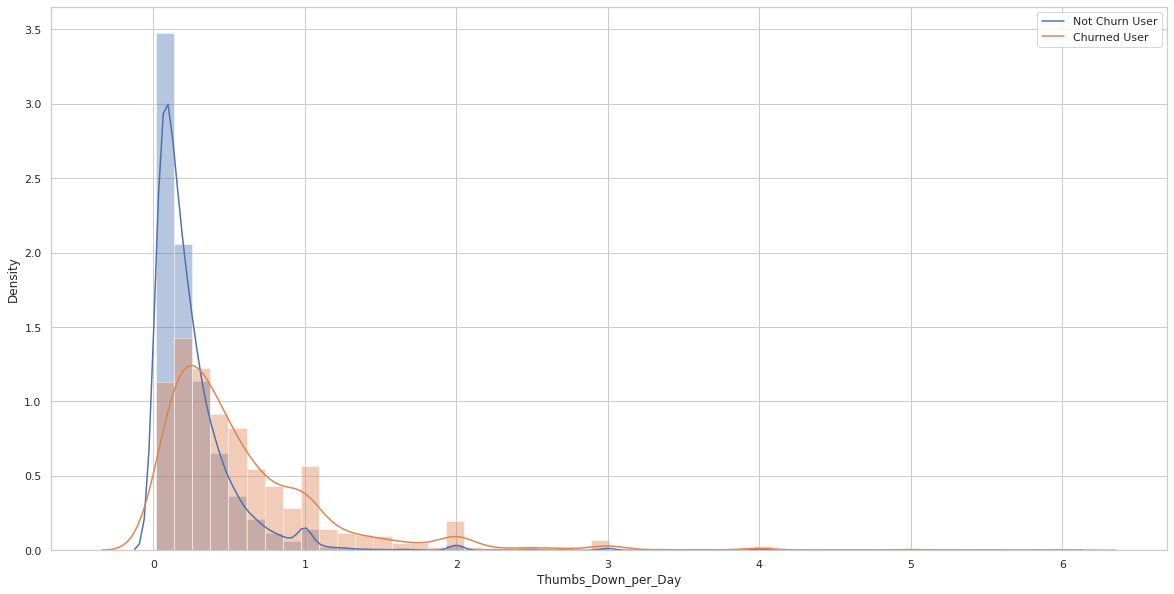

In [ ]:
#Create unique songs by user gordown dataframe
thumbs_down_day_user = df_cleaned.filter(df_cleaned['page'] == 'Thumbs Down').groupBy(['userId','Churned','Time-Span']).agg(count('page').alias('Thumbs_Down_Times'))
thumbs_down_day_user = thumbs_down_day_user.withColumn('Thumbs_Down_per_Day', col("Thumbs_Down_Times")/col('Time-Span'))
thumbs_down_day_user_pd = thumbs_down_day_user.toPandas()
thumbs_down_day_user = thumbs_down_day_user.drop('Churned','Thumbs_Down_Times','Time-Span')

#Plot our result to check average session length of different churned user grodown
plt.figure(figsize = [20,10])
sb.distplot(thumbs_down_day_user_pd[thumbs_down_day_user_pd['Churned'] == 0]['Thumbs_Down_per_Day'])
sb.distplot(thumbs_down_day_user_pd[thumbs_down_day_user_pd['Churned'] == 1]['Thumbs_Down_per_Day'])
plt.legend(['Not Churn User','Churned User'])

#Print out textual conclusion of our result
thumbs_down_day_user_nonchurn = thumbs_down_day_user_pd[thumbs_down_day_user_pd['Churned'] == 0]['Thumbs_Down_per_Day'].mean()
thumbs_down_day_user_churn = thumbs_down_day_user_pd[thumbs_down_day_user_pd['Churned'] == 1]['Thumbs_Down_per_Day'].mean()
print("The mean value of thumbs down per day by churned user grodowns are:\nChurned Users: {}\nNon-Churned Users: {}".format(thumbs_down_day_user_churn, thumbs_down_day_user_nonchurn))

### Thumbs Up Ratio

The average thumbs up ratio for churned user grodowns are:
Churned Users: 0.7854329675622295
Non-Churned Users: 0.8157294475241931


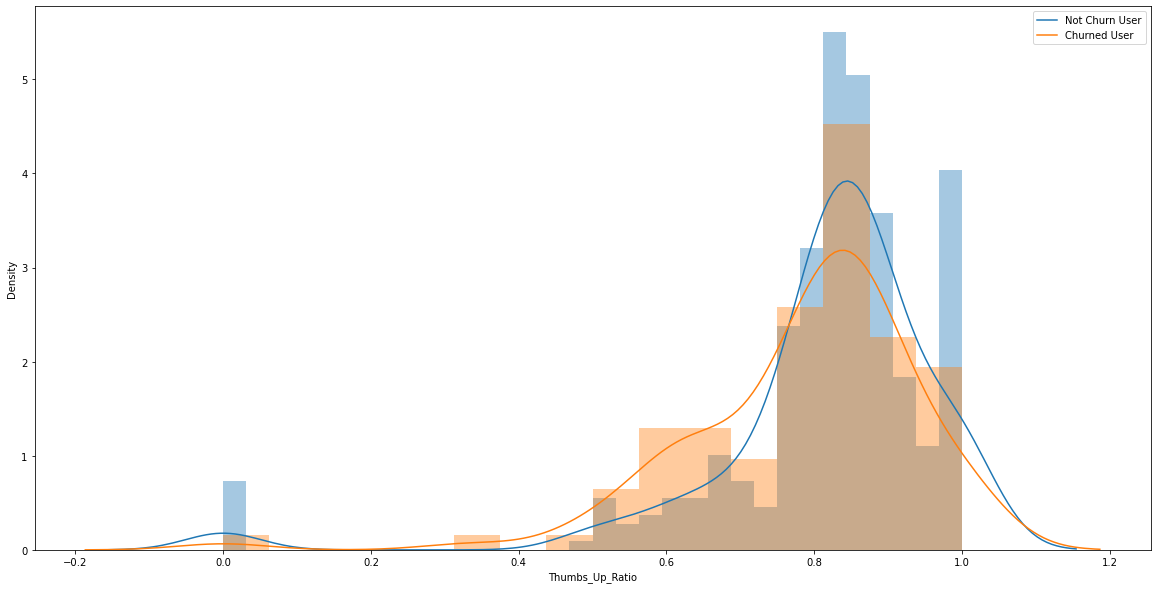

In [ ]:
thumbs_up_ratio = churned_users_table.join(thumbs_up_user, on = 'userId', how = 'left')
thumbs_up_ratio = thumbs_up_ratio.join(thumbs_down_user, on = 'userId', how = 'left')
thumbs_up_ratio = thumbs_up_ratio.fillna(0)
thumbs_up_ratio = thumbs_up_ratio.withColumn("Thumbs_Up_Ratio", col('Total_Thumbs_Up')/(col('Total_Thumbs_Down')+col('Total_Thumbs_Up')))
thumbs_up_ratio = thumbs_up_ratio.fillna(0)
thumbs_up_ratio_pd = thumbs_up_ratio.toPandas()
thumbs_up_ratio = thumbs_up_ratio.drop('Churned', 'Total_Thumbs_Up', 'Total_Thumbs_Down')

#Plot our result 
plt.figure(figsize = [20,10])
sb.distplot(thumbs_up_ratio_pd[thumbs_up_ratio_pd['Churned'] == 0]['Thumbs_Up_Ratio'])
sb.distplot(thumbs_up_ratio_pd[thumbs_up_ratio_pd['Churned'] == 1]['Thumbs_Up_Ratio'])
plt.legend(['Not Churn User','Churned User'])

#Print out textual conclusion of our result
thumbs_up_ratio_nonchurn = thumbs_up_ratio_pd[thumbs_up_ratio_pd['Churned'] == 0]['Thumbs_Up_Ratio'].mean()
thumbs_up_ratio_churn = thumbs_up_ratio_pd[thumbs_up_ratio_pd['Churned'] == 1]['Thumbs_Up_Ratio'].mean()
print("The average thumbs up ratio for churned user grodowns are:\nChurned Users: {}\nNon-Churned Users: {}".format(thumbs_up_ratio_churn, thumbs_up_ratio_nonchurn))

### Churn Gender Analysis

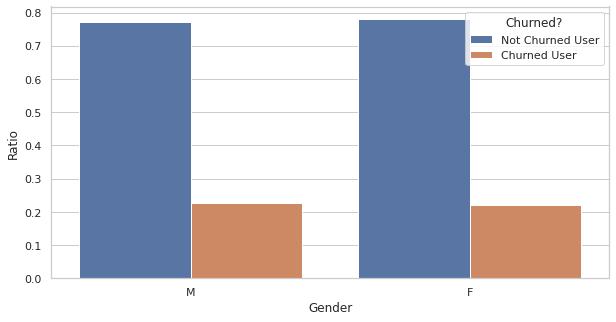

In [ ]:
#We create gender churn statistic by groupBy method
gender_user = df_cleaned.groupBy(['userId','gender']).agg(sql_func.max('Cancel').alias("Churned"))
gender_churn_pd = gender_user.groupBy(['gender','Churned']).count().toPandas()
gender_user = gender_user.drop('Churned')

#Calculate number of male and female users
num_female = gender_churn_pd[gender_churn_pd['gender'] == 'F']['count'].sum()
num_male = gender_churn_pd[gender_churn_pd['gender'] == 'M']['count'].sum()

#Transform counts to ratio
gender_churn_pd.loc[gender_churn_pd['gender'] == 'F', 'count'] /= num_female
gender_churn_pd.loc[gender_churn_pd['gender'] == 'M', 'count'] /= num_male
gender_churn_pd.columns = ['gender', 'Churned', 'ratio']

#Plot results using barplot with hue Churned
plt.figure(figsize = [10, 5])
gender_churn_bar = sb.barplot(x = 'gender', y = 'ratio', data = gender_churn_pd, hue = 'Churned')
plt.ylabel('Ratio')
plt.xlabel('Gender')
h, l = gender_churn_bar.get_legend_handles_labels() 
gender_churn_bar.legend(h, ['Not Churned User', 'Churned User'], title = 'Churned?', loc = 'upper right')

### Unique Songs

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


The mean value of unique songs for churned user groups are:
Churned Users: 779.733106757297
Non-Churned Users: 843.5401819340634


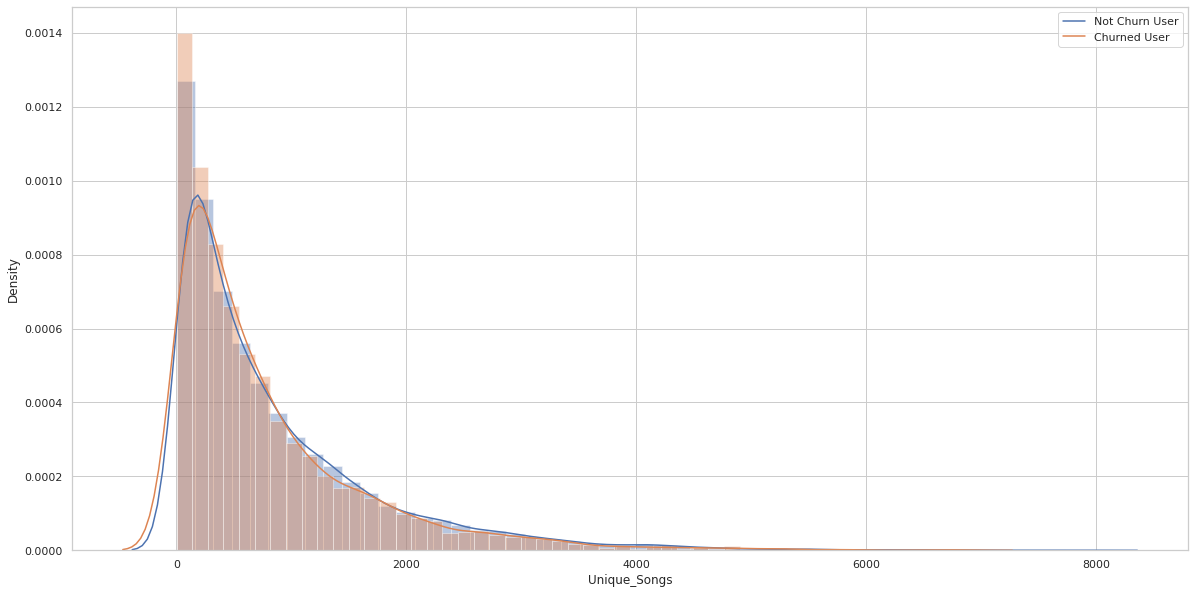

In [ ]:
#Create unique songs by user gorup dataframe
unique_songs_user = df_cleaned.filter(df['song'].isNotNull()).dropDuplicates(subset = ['userId', 'Churned', 'song']).groupBy(['userId','Churned']).agg(count('song').alias('Unique_Songs'))
unique_songs_user_pd = unique_songs_user.toPandas()
unique_songs_user = unique_songs_user.drop('Churned')

#Plot our result
plt.figure(figsize = [20,10])
sb.distplot(unique_songs_user_pd[unique_songs_user_pd['Churned'] == 0]['Unique_Songs'])
sb.distplot(unique_songs_user_pd[unique_songs_user_pd['Churned'] == 1]['Unique_Songs'])
plt.legend(['Not Churn User','Churned User'])

#Print out textual conclusion of our result
unique_songs_nonchurn = unique_songs_user_pd[unique_songs_user_pd['Churned'] == 0]['Unique_Songs'].mean()
unique_songs_churn = unique_songs_user_pd[unique_songs_user_pd['Churned'] == 1]['Unique_Songs'].mean()
print("The mean value of unique songs for churned user groups are:\nChurned Users: {}\nNon-Churned Users: {}".format(unique_songs_churn, unique_songs_nonchurn))

### Unique Artists

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


The mean value of unique artists for churned user groups are:
Churned Users: 610.6683326669332
Non-Churned Users: 654.9896285995712


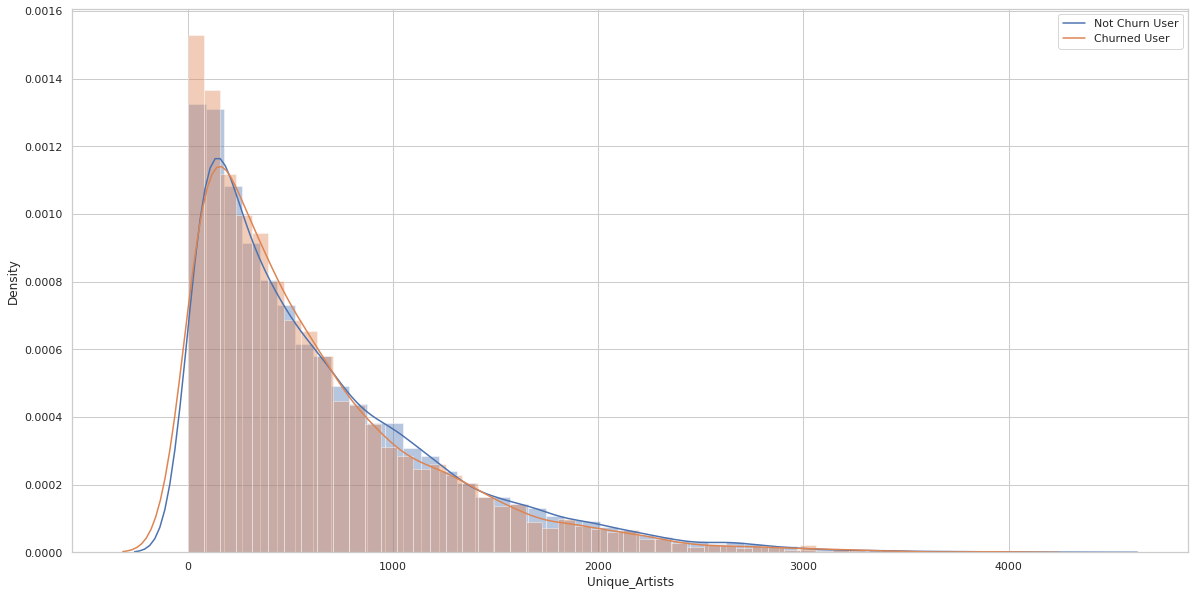

In [ ]:
#Create unique songs by user gorup dataframe
unique_artists_user = df_cleaned.filter(df['artist'].isNotNull()).dropDuplicates(subset = ['userId', 'Churned', 'artist']).groupBy(['userId','Churned']).agg(count('artist').alias('Unique_Artists'))
unique_artists_user_pd = unique_artists_user.toPandas()
unique_artists_user = unique_artists_user.drop('Churned')

#Plot our result
plt.figure(figsize = [20,10])
sb.distplot(unique_artists_user_pd[unique_artists_user_pd['Churned'] == 0]['Unique_Artists'])
sb.distplot(unique_artists_user_pd[unique_artists_user_pd['Churned'] == 1]['Unique_Artists'])
plt.legend(['Not Churn User','Churned User'])

#Print out textual conclusion of our result
unique_artists_nonchurn = unique_artists_user_pd[unique_artists_user_pd['Churned'] == 0]['Unique_Artists'].mean()
unique_artists_churn = unique_artists_user_pd[unique_artists_user_pd['Churned'] == 1]['Unique_Artists'].mean()
print("The mean value of unique artists for churned user groups are:\nChurned Users: {}\nNon-Churned Users: {}".format(unique_artists_churn, unique_artists_nonchurn))

### Average Item in Session

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


The mean value of avgerage item in session for churned user groups are:
Churned Users: 84.52585601628695
Non-Churned Users: 79.72058561476243


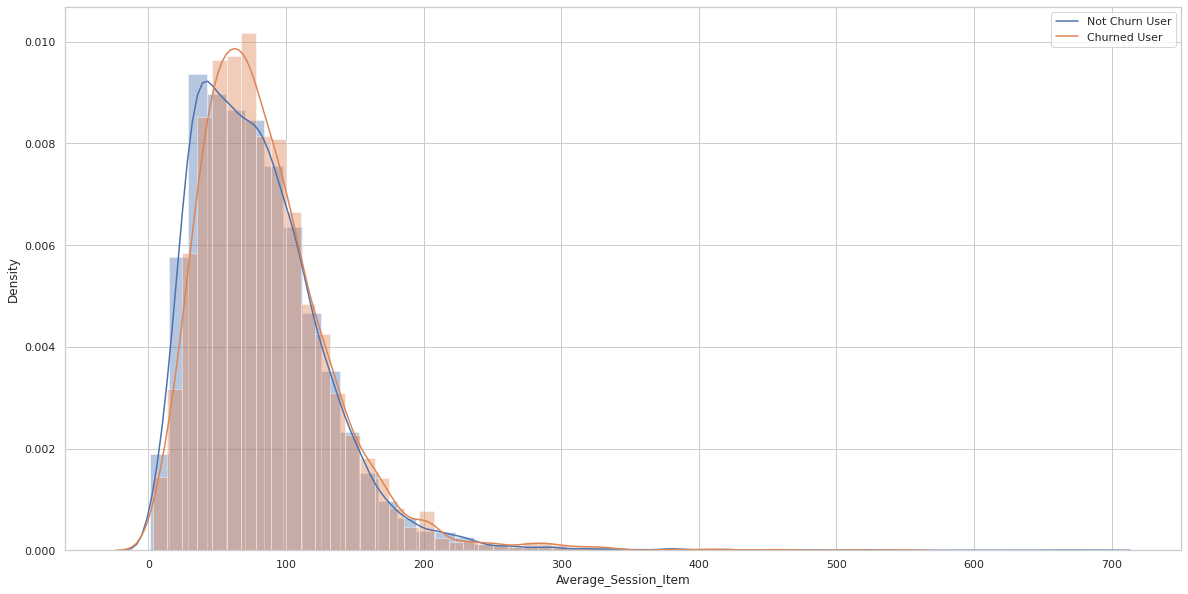

In [ ]:
##Create average items in session by user group dataframe
avg_item_session = df_cleaned.groupBy(['userId','Churned','sessionId']).count().groupBy(['userId','Churned']).agg(avg('count').alias('Average_Session_Item'))
avg_item_session_pd = avg_item_session.toPandas()
avg_item_session = avg_item_session.drop('Churned')

#Plot our result 
plt.figure(figsize = [20,10])
sb.distplot(avg_item_session_pd[avg_item_session_pd['Churned'] == 0]['Average_Session_Item'])
sb.distplot(avg_item_session_pd[avg_item_session_pd['Churned'] == 1]['Average_Session_Item'])
plt.legend(['Not Churn User','Churned User'])


#Print out textual conclusion of our result
avg_item_session_nonchurn = avg_item_session_pd[avg_item_session_pd['Churned'] == 0]['Average_Session_Item'].mean()
avg_item_session_churn = avg_item_session_pd[avg_item_session_pd['Churned'] == 1]['Average_Session_Item'].mean()
print("The mean value of avgerage item in session for churned user groups are:\nChurned Users: {}\nNon-Churned Users: {}".format(avg_item_session_churn, avg_item_session_nonchurn))

### Total Friends

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


The mean value of total friends for churned user groups are:
Churned Users: 17.736643759698516
Non-Churned Users: 19.09927820691402


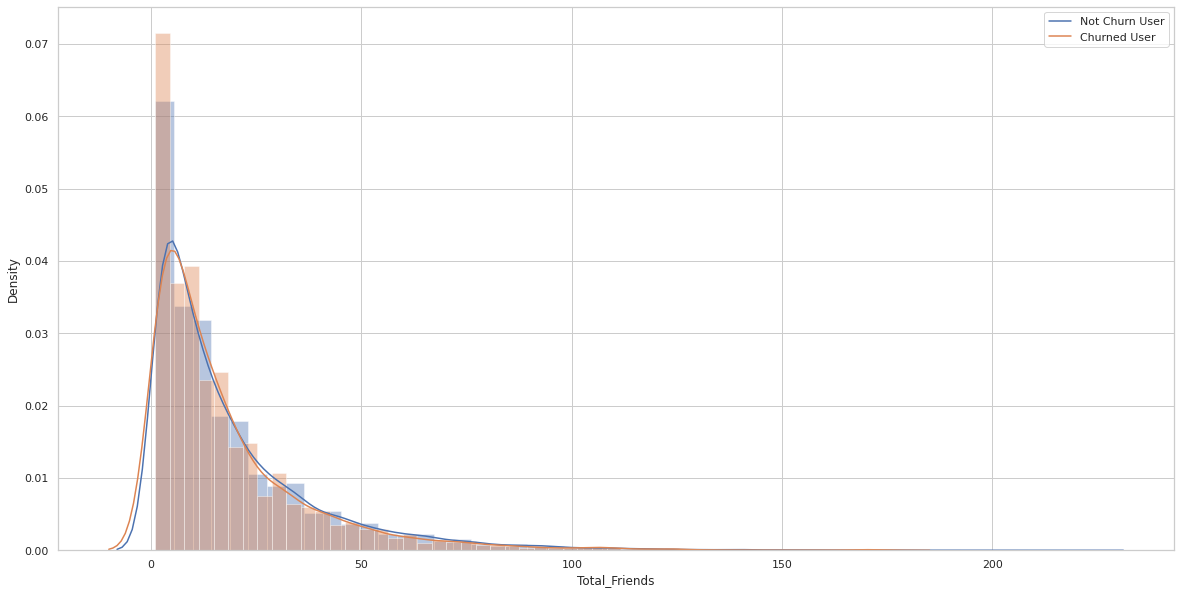

In [ ]:
#Create total friends of by user group dataframe
total_Friends = df_cleaned.filter(df['page'] == 'Add Friend').groupBy(['userId','Churned']).agg(count('page').alias('Total_Friends'))
total_Friends_pd = total_Friends.toPandas()
total_Friends = total_Friends.drop('Churned')

#Plot our result
plt.figure(figsize = [20,10])
sb.distplot(total_Friends_pd[total_Friends_pd['Churned'] == 0]['Total_Friends'])
sb.distplot(total_Friends_pd[total_Friends_pd['Churned'] == 1]['Total_Friends'])
plt.legend(['Not Churn User','Churned User'])

#Print out textual conclusion of our result
total_Friends_nonchurn = total_Friends_pd[total_Friends_pd['Churned'] == 0]['Total_Friends'].mean()
total_Friends_churn = total_Friends_pd[total_Friends_pd['Churned'] == 1]['Total_Friends'].mean()
print("The mean value of total friends for churned user groups are:\nChurned Users: {}\nNon-Churned Users: {}".format(total_Friends_churn, total_Friends_nonchurn))

### Membership Duration

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


The mean value of membership duration for churned user groups are:
Churned Users: 63.71881719579359
Non-Churned Users: 89.08563652583224


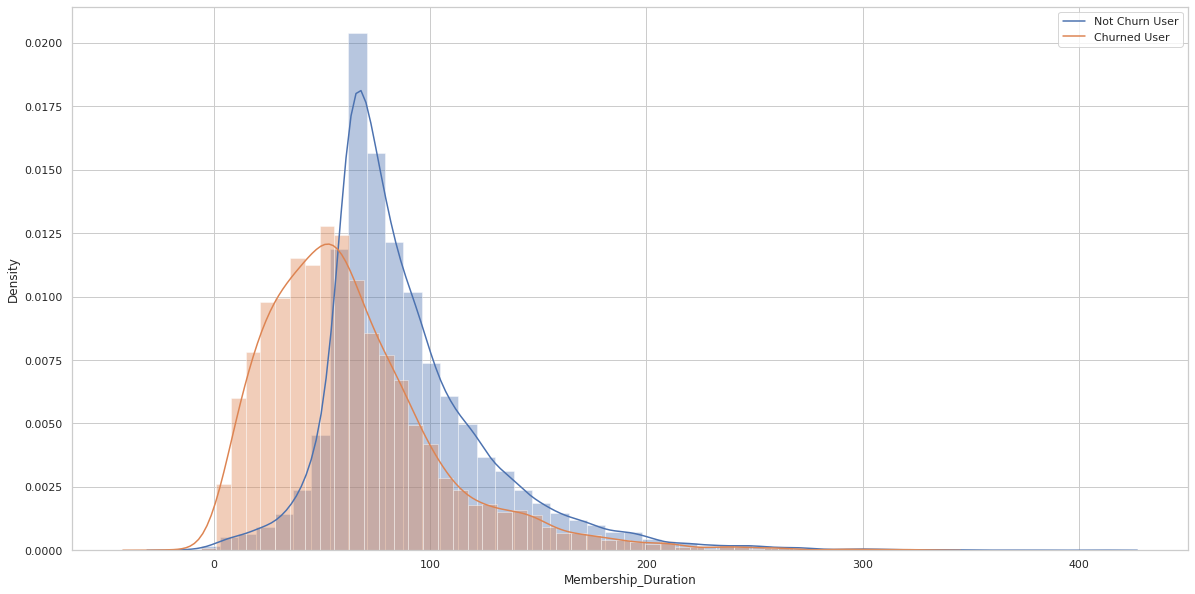

In [ ]:
register_user = df_cleaned.orderBy(['userId','ts'], ascending = False).groupBy(['userId','Churned','registration']).agg(first('ts').alias("Last_Log_Time"))
register_user = register_user.withColumn('Membership_Duration', (col('Last_Log_Time')-col('registration'))/86400000)
register_user_pd = register_user.toPandas()
register_user = register_user.drop("Last_Log_Time","Churned","registration")

#Plot our result 
plt.figure(figsize = [20,10])
sb.distplot(register_user_pd[register_user_pd['Churned'] == 0]['Membership_Duration'])
sb.distplot(register_user_pd[register_user_pd['Churned'] == 1]['Membership_Duration'])
plt.legend(['Not Churn User','Churned User'])

#Print out textual conclusion of our result
member_duration_nonchurn = register_user_pd[register_user_pd['Churned'] == 0]['Membership_Duration'].mean()
member_duration_churn = register_user_pd[register_user_pd['Churned'] == 1]['Membership_Duration'].mean()
print("The mean value of membership duration for churned user groups are:\nChurned Users: {}\nNon-Churned Users: {}".format(member_duration_churn, member_duration_nonchurn))

### Errors per Day

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


The mean value of error day user encountered by churned user groups are:
Churned Users: 0.1059777555740144
Non-Churned Users: 0.04860199159005812


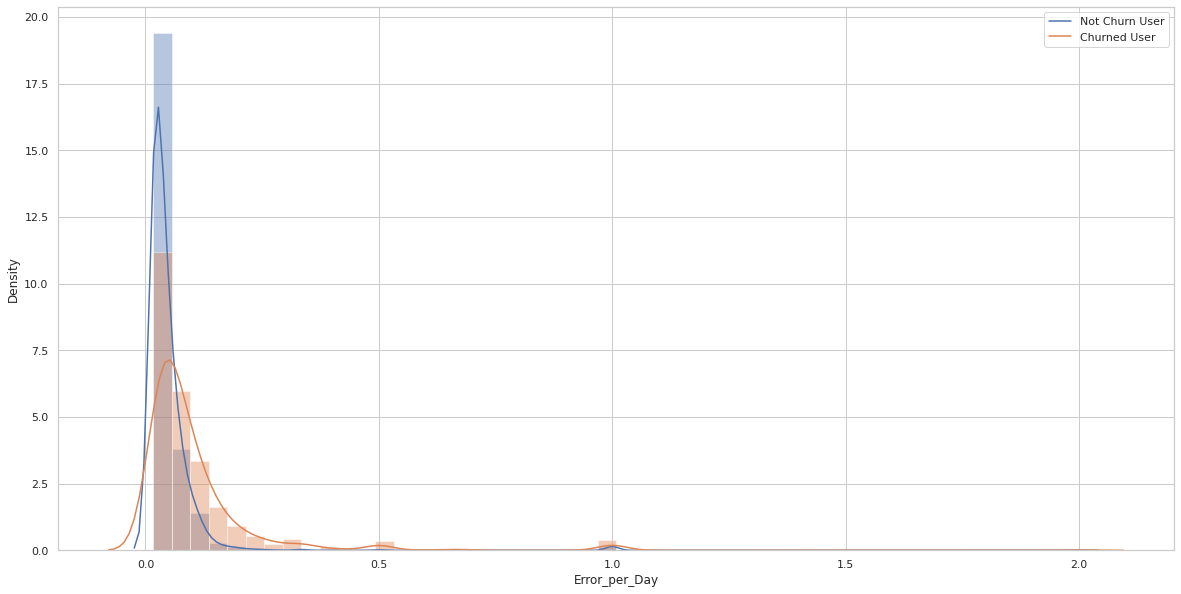

In [ ]:
#Create unique songs by user group dataframe
error_day_user = df_cleaned.filter(df_cleaned['page'] == 'Error').groupBy(['userId','Churned','Time-Span']).agg(count('page').alias('Error_Times'))
error_day_user = error_day_user.withColumn('Error_per_Day', col("Error_Times")/col('Time-Span'))
error_day_user_pd = error_day_user.toPandas()
error_day_user = error_day_user.drop('Churned','Error_Times','Time-Span')

#Plot our result to check average session length of different churned user group
plt.figure(figsize = [20,10])
sb.distplot(error_day_user_pd[error_day_user_pd['Churned'] == 0]['Error_per_Day'])
sb.distplot(error_day_user_pd[error_day_user_pd['Churned'] == 1]['Error_per_Day'])
plt.legend(['Not Churn User','Churned User'])

#Print out textual conclusion of our result
error_day_user_nonchurn = error_day_user_pd[error_day_user_pd['Churned'] == 0]['Error_per_Day'].mean()
error_day_user_churn = error_day_user_pd[error_day_user_pd['Churned'] == 1]['Error_per_Day'].mean()
print("The mean value of error day user encountered by churned user groups are:\nChurned Users: {}\nNon-Churned Users: {}".format(error_day_user_churn, error_day_user_nonchurn))

# Feature Engineering


In [ ]:
#get churned user by max value
User_Feature_Dataframe = df_cleaned.groupBy('userId').agg(sql_func.max('Cancel').alias('Churned'))

In [ ]:
final_level = df_cleaned.orderBy(['userId','ts'],ascending = False).groupBy(['userId','Churned']).agg(first('level').alias('Final_Level'))
final_level = final_level.drop('Churned')

session_month_user = df_cleaned.groupBy(['userId','Churned','Time-Span','sessionId']).count().groupBy(['userId','Churned','Time-Span']).agg(count('sessionId').alias('Num_of_Sessions'))
session_month_user = session_month_user.withColumn('Sessions_per_Month', col("Num_of_Sessions")/col('Time-Span')*30)
session_month_user = session_month_user.drop('Churned',"Num_of_Sessions",'Time-Span')

thumbs_up_user = df_cleaned.filter(df_cleaned['page'] == 'Thumbs Up').groupBy(['userId','Churned']).agg(count('page').alias('Total_Thumbs_Up'))
thumbs_up_user = thumbs_up_user.drop('Churned')

thumbs_down_user = df_cleaned.filter(df_cleaned['page'] == 'Thumbs Down').groupBy(['userId','Churned']).agg(count('page').alias('Total_Thumbs_Down'))
thumbs_down_user = thumbs_down_user.drop('Churned')

thumbs_up_day_user = df_cleaned.filter(df_cleaned['page'] == 'Thumbs Up').groupBy(['userId','Churned','Time-Span']).agg(count('page').alias('Thumbs_Up_Times'))
thumbs_up_day_user = thumbs_up_day_user.withColumn('Thumbs_Up_per_Day', col("Thumbs_Up_Times")/col('Time-Span'))
thumbs_up_day_user = thumbs_up_day_user.drop('Churned','Thumbs_Up_Times','Time-Span')

thumbs_down_day_user = df_cleaned.filter(df_cleaned['page'] == 'Thumbs Down').groupBy(['userId','Churned','Time-Span']).agg(count('page').alias('Thumbs_Down_Times'))
thumbs_down_day_user = thumbs_down_day_user.withColumn('Thumbs_Down_per_Day', col("Thumbs_Down_Times")/col('Time-Span'))
thumbs_down_day_user = thumbs_down_day_user.drop('Churned','Thumbs_Down_Times','Time-Span')

thumbs_up_ratio = churned_users_table.join(thumbs_up_user, on = 'userId', how = 'left')
thumbs_up_ratio = thumbs_up_ratio.join(thumbs_down_user, on = 'userId', how = 'left')
thumbs_up_ratio = thumbs_up_ratio.fillna(0)
thumbs_up_ratio = thumbs_up_ratio.withColumn("Thumbs_Up_Ratio", col('Total_Thumbs_Up')/(col('Total_Thumbs_Down')+col('Total_Thumbs_Up')))
thumbs_up_ratio = thumbs_up_ratio.fillna(0)
thumbs_up_ratio = thumbs_up_ratio.drop('Churned', 'Total_Thumbs_Up', 'Total_Thumbs_Down')

register_user = df_cleaned.orderBy(['userId','ts'], ascending = False).groupBy(['userId','Churned','registration']).agg(first('ts').alias("Last_Log_Time"))
register_user = register_user.withColumn('Membership_Duration', (col('Last_Log_Time')-col('registration'))/86400000)
register_user = register_user.drop("Last_Log_Time","Churned","registration")

error_day_user = df_cleaned.filter(df_cleaned['page'] == 'Error').groupBy(['userId','Churned','Time-Span']).agg(count('page').alias('Error_Times'))
error_day_user = error_day_user.withColumn('Error_per_Day', col("Error_Times")/col('Time-Span'))
error_day_user = error_day_user.drop('Churned','Error_Times','Time-Span')


### Final Level

In [ ]:
#Check the final state of each user (latest log record)
User_Feature_Dataframe = User_Feature_Dataframe.join(final_level, on='userId', how = 'left')

### Sessions per Month

In [ ]:
#Create sessions per month column
User_Feature_Dataframe = User_Feature_Dataframe.join(session_month_user, on='userId', how = 'left')

### Thumbs Up per Day

In [ ]:
#We create total number of thumbs up of each user
User_Feature_Dataframe = User_Feature_Dataframe.join(thumbs_up_day_user, on='userId', how = 'left')

### Thumbs Down per Day

In [ ]:
#We create thumbs down per day of each user
User_Feature_Dataframe = User_Feature_Dataframe.join(thumbs_down_day_user, on='userId', how = 'left')

### Thumbs Up Ratio

In [ ]:
#Join our result to the seed dataframe
User_Feature_Dataframe = User_Feature_Dataframe.join(thumbs_up_ratio, on='userId', how = 'left')

### Membership Duration

In [ ]:
#Create membership duration column
User_Feature_Dataframe = User_Feature_Dataframe.join(register_user, on='userId', how = 'left')

### Errors per Day

In [ ]:
#Create errors per day column
User_Feature_Dataframe = User_Feature_Dataframe.join(error_day_user, on='userId', how = 'left')

### Fill Null Values

In [ ]:
#Fill all null value in our dataframe 0
User_Feature_Dataframe = User_Feature_Dataframe.fillna(0)

### Backup Features DataFrame

In [ ]:
#Backup features dataframe
User_Feature_Dataframe.write.mode('overwrite').parquet('User_Feature_Dataframe.parquet')

In [ ]:
#Reload dataframe
User_Feature_Dataframe = spark.read.parquet('drive/My Drive/Data/User_Feature_Dataframe.parquet')

In [ ]:
User_Feature_Dataframe.show(5)

+-------+-------+-----------+------------------+-------------------+-------------------+------------------+-------------------+--------------------+
| userId|Churned|Final_Level|Sessions_per_Month|  Thumbs_Up_per_Day|Thumbs_Down_per_Day|   Thumbs_Up_Ratio|Membership_Duration|       Error_per_Day|
+-------+-------+-----------+------------------+-------------------+-------------------+------------------+-------------------+--------------------+
|1000280|      1|       free|              15.0| 1.2045454545454546|               0.75|0.6162790697674418|  77.30377314814815| 0.06818181818181818|
|1002185|      0|       paid| 8.793103448275861| 1.5862068965517242| 0.2413793103448276|0.8679245283018868|  65.75105324074075|0.034482758620689655|
|1017805|      0|       paid|3.5999999999999996|               0.28|               0.16|0.6363636363636364|  54.26638888888889|                 0.0|
|1030587|      0|       paid|               6.6|               1.32|               0.32|0.8048780487804879

# Modeling

## Data Preprocessing

In [ ]:
# Create a StringIndexer, OneHotEncoder
level_indexer = StringIndexer(inputCol="Final_Level", outputCol="level_index")

level_encoder = OneHotEncoder(inputCol="level_index", outputCol="level_fact")

# Make a VectorAssembler
vec_assembler1 = VectorAssembler(
    inputCols=["Sessions_per_Month", "Thumbs_Up_per_Day", "Thumbs_Down_per_Day", "Thumbs_Up_Ratio", "Membership_Duration", "Error_per_Day"], outputCol="num_features")
scaler = StandardScaler(withMean = True, withStd = True, inputCol = "num_features", outputCol = "num_std_features")

vec_assembler2 = VectorAssembler(inputCols = ['num_std_features', 'level_fact'], outputCol = "features")

# Make the pipeline
pipe = Pipeline(stages=[level_indexer, level_encoder, vec_assembler1, scaler, vec_assembler2])


In [ ]:
#Extract feature and label column and save the dataframe to a parquet file
pipe_data = pipe.fit(User_Feature_Dataframe).transform(User_Feature_Dataframe)
ml_data = pipe_data.select(col('features'), col('Churned').alias('label'))
# ml_data.write.mode('overwrite').parquet('ml_data_medium.parquet')

In [ ]:
#Reload the parquet file
ml_data = spark.read.parquet('drive/My Drive/Data/ml_data.parquet')

In [ ]:
ml_data.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[3.06722464641731...|    0|
|[1.80222083980637...|    1|
|[-0.7314587728541...|    0|
|[1.80222083980637...|    0|
|[-0.7775722541765...|    0|
+--------------------+-----+
only showing top 5 rows



## Handling Imbalanced Dataset


In [ ]:
#import function used in this section
def evaluation(pred_table):
    #Find out True Postive(TP), False Positive(FP), True Negative(TN) and False Negative(FN)
    TP = pred_table.filter((pred_table.label == 1)&(pred_table.prediction == 1)).count()
    FP = pred_table.filter((pred_table.label == 0)&(pred_table.prediction == 1)).count()
    TN = pred_table.filter((pred_table.label == 0)&(pred_table.prediction == 0)).count()
    FN = pred_table.filter((pred_table.label == 1)&(pred_table.prediction == 0)).count()
    
    #Calculate accuracy, recall, precision and f1_score 
    num_of_test_sample = pred_table.count()
    accuracy = (TP + TN) / num_of_test_sample
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    f1_score = 2 * precision*recall / (precision + recall)
    
    return accuracy, recall, precision, f1_score

def create_balanced_table(df, pos_neg_ratio):
    num_of_pos = df.filter(df['label'] == 1).count()
    positives = df.filter(df['label'] == 1)
    negatives = df.filter(df['label'] == 0)

    to_add = negatives.orderBy(rand()).limit(round(num_of_pos/pos_neg_ratio))
    balanced_df = positives.union(to_add)
    return balanced_df

In [ ]:
#Resample the training set to create more balanced dataset using ratio we just optimized
balanced_dataset = create_balanced_table(ml_data, 0.1)
training_bal, test_bal = balanced_dataset.randomSplit([0.7, 0.3], seed = 6)
balanced_dataset.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1| 5003|
|    0|17274|
+-----+-----+



## Fitting Data to Estimators


### Logistic Regression Fitting
paramgrid and crossvalidator to help tune hyperparameters which in this case are regParam. 

In [ ]:
lr_bal = LogisticRegression()

paramGrid_lr_bal = ParamGridBuilder().addGrid(lr_bal.regParam, [0, 0.1]).build()
evaluator_lr_bal = BinaryClassificationEvaluator()

crossval_lr_bal = CrossValidator(estimator = lr_bal,
                          estimatorParamMaps = paramGrid_lr_bal,
                          evaluator = evaluator_lr_bal,
                          numFolds = 8)

lrModel_bal = crossval_lr_bal.fit(training_bal)

In [ ]:
#Save the model
lrModel_bal.write().overwrite().save('lrModel_bal')


### Random Forest Fitting


In [ ]:
RFC_bal = RandomForestClassifier(labelCol= "label", featuresCol="features")

paramGrid_rfc_bal = ParamGridBuilder().addGrid(RFC_bal.numTrees, [10, 15, 20, 25]).addGrid(RFC_bal.maxDepth, [3,5,7]).build()
evaluator_rfc_bal = BinaryClassificationEvaluator()

crossval_rfc_bal = CrossValidator(estimator = RFC_bal,
                          estimatorParamMaps = paramGrid_rfc_bal,
                          evaluator = evaluator_rfc_bal,
                          numFolds = 8)

rfcModel_bal = crossval_rfc_bal.fit(training_bal)

In [ ]:
#Save the model 
rfcModel_bal.write().overwrite().save('rfcModel_bal')

## Evaluating Model

In [ ]:
#Show positive and negative label quantity of test set
test_bal.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1| 1544|
|    0| 5122|
+-----+-----+



In [ ]:
evaluator_bal = BinaryClassificationEvaluator(metricName='areaUnderROC')

temp_dict = {'Logistic': lrModel_bal, "RandomForest": rfcModel_bal}

model_metrics = {}

for model_name in temp_dict.keys():
    
    #evaluate using test_balanced set
    temp_model = temp_dict[model_name].bestModel
    temp_test = temp_model.transform(test_bal)
    AUC = evaluator_bal.evaluate(temp_test)
    acc, rec, prec, f1 = evaluation(temp_test)
    model_metrics[model_name + "Test"] = [AUC, acc, rec, prec, f1]
    
    #whole set
    temp_all = temp_model.transform(ml_data)
    AUC = evaluator_bal.evaluate(temp_all)
    acc, rec, prec, f1 = evaluation(temp_all)
    model_metrics[model_name + "All"] = [AUC, acc, rec, prec, f1]
    
#Turn result into dataframe
model_metrics_table_bal = pd.DataFrame(model_metrics, index = ['AUC', 'accuracy', 'recall', 'precision', 'f1_score'])
model_metrics_table_bal

,LogisticTest,LogisticAll,RandomForestTest,RandomForestAll
AUC,0.805727,0.799466,0.849723,0.854926
accuracy,0.813681,0.816223,0.847735,0.856758
recall,0.328368,0.317210,0.453368,0.459724
precision,0.712079,0.700662,0.803674,0.824964
f1_score,0.449468,0.436709,0.579710,0.590425


In [ ]:
#Backup model_metrics table
model_metrics_table_bal.to_csv('model_metrics_bal.csv')

<Figure size 1440x720 with 0 Axes>

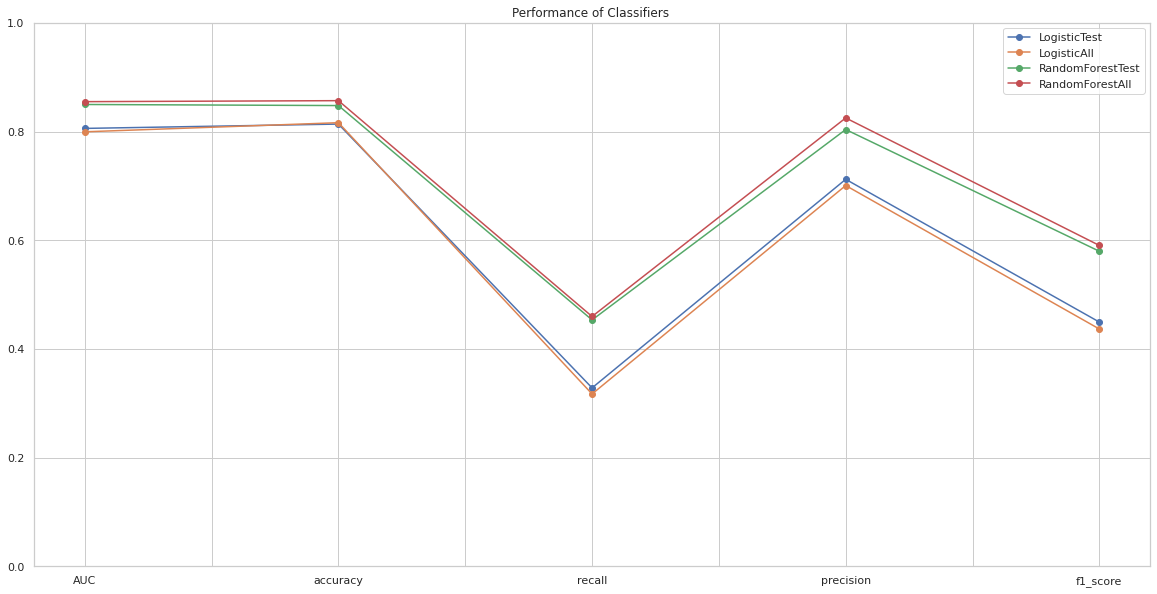

In [ ]:
plt.figure(figsize = [20,10])
model_metrics_table_bal.plot(kind ='line', marker = 'o', figsize = [20,10], ylim=(0,1), title = 'Performance of Classifiers ')